In [1]:
from olfactorybulb.database import *
import os,sys
from neuronunit.tests.olfactory_bulb.publications import *
from neuronunit.tests.olfactory_bulb.tests import *
from neuronunit.models.neuron_cell import NeuronCellModel
from sciunit.suites import TestSuite
from pandas import DataFrame
import quantities as pq
from neuronunit.tests.olfactory_bulb.utilities import cache
from linetimer import CodeTimer
import string

/home/justas/anaconda2/envs/p27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Could not load NEURONBackend


In [7]:
cell_type = 'gc'

# Load tests
measurements = Measurement\
    .select(Measurement)\
    .join(Property)\
    .switch(Measurement)\
    .join(Source)\
    .where((Measurement.property.type == "Electrophysiology") & (Measurement.property.id.startswith(cell_type+'_')))\
    .order_by(Measurement.property.id)

properties = {}

for m in measurements:
    test_generic = str(m.property.test_class_generic)
    pub = str(m.source.publication_class).strip()
    class_name = test_generic+pub
    
    if test_generic not in properties:
        properties[test_generic] = []
    
    globals()[class_name] = type(class_name, 
                                 (eval(pub), eval(test_generic)), 
                                 {})
    
    print('creating specific test class: ' + class_name)
    
    test_instance = eval(class_name)(observation={"mean": m.mean * eval(m.property.units), "std": m.std * eval(m.property.units), "n": m.n})
    
    properties[test_generic].append(test_instance)
    
    
# Load model classes
model_classes = list(CellModel\
                    .select(CellModel)\
                    .where(CellModel.cell_type == cell_type.upper())             
                     )
for i, m in enumerate(model_classes):
    nmsp = string.join(m.isolated_model_class.split('.')[:-1],'.')
    cls = m.isolated_model_class.split('.')[-1]

    import_cmd = 'from '+nmsp+' import '+cls+' as Model'+str(i)
    print(import_cmd)
    exec(import_cmd)
    
# Create work item list
work_items = []

for model in model_classes:
    work_items.append({"model_class": model.isolated_model_class })
        
def dowork(item):
    results = item
    results["properties"] = {}
    
    import prev_ob_models
    exec('cell = '+ str(item["model_class"]) +'()')

    model = NeuronCellModel(cell.soma(0.5),name=cell.__class__.__module__+'.'+cell.__class__.__name__)


    for prop in properties.keys():
        
        if prop not in results["properties"]:
            results["properties"][prop] = { "tests": {}, "total_n": 0, "z_score_combined": None}
        
        tests = properties[prop]
        
        for test in tests:
            
            results["properties"][prop]["tests"][test.__class__.__name__] = {}
            
            try:
                print('Starting', item, test)
                result = test.generate_prediction(model)
                print('Finished', item, test, result)

            except:
                import traceback
                result = traceback.format_exc()
                print(result)
                
            results["properties"][prop]["tests"][test.__class__.__name__]["observation"] = test.observation
            results["properties"][prop]["tests"][test.__class__.__name__]["prediction"] = result
            
            if type(result) != str:
                z_score = (result - test.observation["mean"])/test.observation["std"]
            else:
                z_score = 6.0 # errors are treated as 6 std deviation
                
            z_weighed = z_score * test.observation["n"]

            results["properties"][prop]["tests"][test.__class__.__name__]["z_score"] = z_score
            results["properties"][prop]["tests"][test.__class__.__name__]["z_score_weighed"] = z_weighed
            results["properties"][prop]["total_n"] += test.observation["n"]
            
        results["properties"][prop]["z_score_combined"] = sum([i["z_score_weighed"] for i in results["properties"][prop]["tests"].values()])
        results["properties"][prop]["z_score_combined"] /= results["properties"][prop]["total_n"]

    return results


creating specific test class: SpikeAmplitudeTestBurtonUrban2015
creating specific test class: SpikeHalfWidthTestBurtonUrban2015
creating specific test class: SpikeThresholdTestBurtonUrban2015
creating specific test class: CellCapacitanceTestBurtonUrban2015
creating specific test class: FISlopeTestBurtonUrban2015
creating specific test class: InputResistanceTestBurtonUrban2015
creating specific test class: InputResistanceTestStroh2012
creating specific test class: RestingVoltageTestBurtonUrban2015
creating specific test class: RestingVoltageTestStroh2012
creating specific test class: RheobaseTestBurtonUrban2015
creating specific test class: SagVoltageTestHu2016
creating specific test class: MembraneTimeConstantTestBurtonUrban2015
from prev_ob_models.Davison2003.isolated_cells import GC as Model0
from prev_ob_models.KaplanLansner2014.isolated_cells import GC as Model1
from prev_ob_models.LiCleland2013.isolated_cells import GC as Model2
from prev_ob_models.McTavish2012.isolated_cells impo

	1 
	0 
	1001 
	0 
	0 
	0 
	0 
	0 
	0 
	0 
	0 
	0 
	0 
	0 
	0 
	0 
	0 
('Starting', {'model_class': u'prev_ob_models.Davison2003.isolated_cells.GC', 'properties': {'SpikeThresholdTest': {'tests': {'SpikeThresholdTestBurtonUrban2015': {}}, 'z_score_combined': None, 'total_n': 0}}}, <__main__.SpikeThresholdTestBurtonUrban2015 object at 0x7eff6b4764d0>)


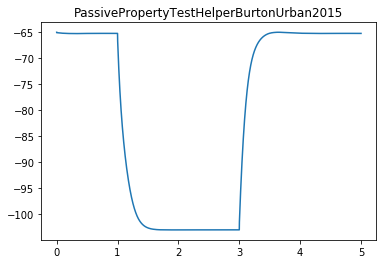

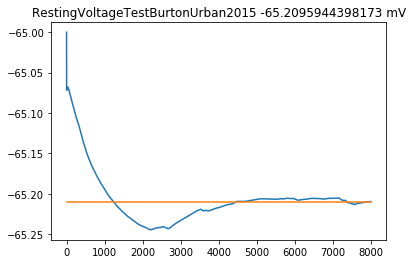

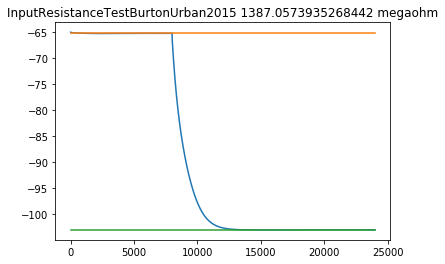

In [ ]:
dowork(work_items[0])

In [4]:
raise

TypeError: exceptions must be old-style classes or derived from BaseException, not NoneType

In [ ]:
# Run the tests
processes = 15   
from multiprocessing import Pool
pool = Pool(processes = processes, maxtasksperchild=1)
result = pool.map(dowork, work_items)
pool.terminate()
pool.join()
result

# Show result in a table
df = []
for model in result:
    row = {"model": model[0]}
    for t, test in enumerate(tests):
        row[test.__class__.__name__] = model[1][t]
    df.append(row)
        
df = DataFrame(df)
df


In [ ]:
result

In [ ]:
prop_test_instance.generate_prediction(model)

In [ ]:
df.to_csv(cell_type+"_model_ephyz_validation_results.csv")

In [ ]:
df_tests = []
row = {"model": "Observations"}
for t, test in enumerate(tests):
    row[test.__class__.__name__ + "_mean"] = test.observation["mean"]
    row[test.__class__.__name__ + "_std"] = test.observation["std"]
    row[test.__class__.__name__ + "_n"] = test.observation["n"]
df_tests.append(row)
        
df_tests = DataFrame(df_tests)
df_tests.to_csv(cell_type+"_model_ephyz_observations.csv")
df_tests

In [ ]:
raise Exception()

In [ ]:
cache.clear()
i = 10 #Max: 10
for item in [work_items[i]]:
    dowork(item)

print("FINISHED")

In [ ]:
raise Exception()

In [ ]:
cache.clear()
import prev_ob_models
cell = prev_ob_models.Saghatelyan2005.isolated_cells.GC()
model = NeuronCellModel(cell.soma(0.5),name=cell.__class__.__module__+'.'+cell.__class__.__name__)
RheobaseTestBurtonUrban2015().generate_prediction(model)

In [ ]:
model = None
cell = None
raise Exception()

In [ ]:
for i, test in enumerate(tests):
    #print(i, 'judging', test)
    print(test.generate_prediction(model))
    

In [ ]:
test.observation

In [ ]:
with CodeTimer():
    TestSuite(tests).judge(model)

In [ ]:
from neuronunit.tests.olfactory_bulb.utilities import cache
#cache.clear()

In [ ]:

class Test(BurtonUrban2015, SpikeThresholdTest):
    pass

test = Test().generate_prediction(model)

In [ ]:
test

In [ ]:
#rb = RheobaseTestBurtonUrban2014().generate_prediction(model)
rb = 0.02438785 * pq.nA

In [ ]:
SpikeAccommodationTimeConstantTestZibman2011(rb).generate_prediction(model)

In [ ]:
SpikeAccommodationTestBurtonUrban2014(rb).generate_prediction(model)

In [ ]:
ISICVTestBurtonUrban2014(rb).generate_prediction(model)

In [ ]:
rb = RheobaseTestYu2015().generate_prediction(model)

In [ ]:
ISICVTestYu2015(rb).generate_prediction(model)

In [ ]:
0/0

In [ ]:
ReboundSpikingTestBurtonUrban2014().generate_prediction(model)

In [ ]:
ReboundSpikingTestJohnsonDelaney2010().generate_prediction(model)

In [ ]:
rb = RheobaseTestBurtonUrban2014().generate_prediction(model)
rb

In [ ]:
voltage = model.inject_square_current({"delay": 1000*pq.ms,"duration": 2000*pq.ms, "amplitude": rb})

In [ ]:
plt.plot(voltage)

In [ ]:
voltage.magnitude[np.where(voltage.times > 1000*pq.ms)]

In [ ]:
rb = 0.02438782 * pq.nA

In [ ]:
# %matplotlib notebook
# %matplotlib notebook
# %matplotlib notebook
# %matplotlib notebook

In [ ]:
rb = RheobaseTestYu2015().generate_prediction(model)
rb

In [ ]:
SagVoltageTestAngelo2012().generate_prediction(model)
SagVoltageTestBurtonUrban2014().generate_prediction(model)
SagVoltageTestYu2015().generate_prediction(model)
SagVoltageTestHu2016().generate_prediction(model)

In [ ]:
AfterHyperpolarizationAmplitudeTestYu2015(rb).generate_prediction(model)

In [ ]:
AfterHyperpolarizationTimeTestYu2015(rb).generate_prediction(model)

In [ ]:
AfterHyperpolarizationAmplitudeTestBurtonUrban2014(rb).generate_prediction(model)

In [ ]:
AfterHyperpolarizationTimeTestBurtonUrban2014(rb).generate_prediction(model)

In [ ]:
1/0

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

v = aps[0]
plt.plot(v["voltage"])
#plt.plot(v3_z[0:get_zero_crossings(v3_z)[0]+1])
#plt.xlim((0,80))
plt.show()

In [ ]:
test1 = SagVoltageTestAngelo2012(observation={"mean":0*pq.mV, 'std':1*pq.mV,'n': 10})
test2 = SagVoltageTestBurtonUrban2014(observation={"mean":0*pq.mV, 'std':1*pq.mV,'n': 10})
test3 = SagVoltageTestYu2015(observation={"mean":0*pq.mV, 'std':1*pq.mV,'n': 10})
test4 = SagVoltageTestHu2016(observation={"mean":0*pq.mV, 'std':1*pq.mV,'n': 10})

#suite = test1 
suite = TestSuite(tests=[test1,test2,test3,test4])

In [ ]:
suite.judge(model)